This notebook was modified from the DSBA-6190 Project 2 notebook to incorporate use of Amazon Sagemaker.

The Wine Quality Dataset (https://archive.ics.uci.edu/ml/datasets/Wine+Quality) was used as the data input. Several regression models were generated, using the provided data to predict red wine quality.

# Import

## Libraries / Packages

In [50]:
# General
import pandas as pd
import numpy as np
import json
import os
import tarfile

#SageMaker
import boto3
import io
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.estimator import SKLearn

# Visual
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 
matplotlib.style.use('ggplot')

# Data Preparation
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Modeling
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Output
from sklearn.metrics import mean_squared_error,r2_score
from statistics import mean 

# Export
from sklearn.externals import joblib
#from google.colab import files

seed = 5590

## Sagemaker Settings

In [2]:
region = boto3.session.Session().region_name

role = get_execution_role()
role

'arn:aws:iam::726963482731:role/service-role/AmazonSageMaker-ExecutionRole-20200222T172260'

## Data

Initialize the S3 connection and name the target bucket.

In [3]:
s3_client = boto3.client('s3')
data_bucket_name='dsba-6190-final-team-project'

Check the contents of the bucket, and assign the import data file path and name to the variable **file_data**.

In [4]:
obj_list=s3_client.list_objects(Bucket=data_bucket_name)
file=[]
for contents in obj_list['Contents']:
    file.append(contents['Key'])
print(file)
file_data=file[1]

['data/', 'data/winequality-red.csv']


In [5]:
file_data

'data/winequality-red.csv'

Import the data into the variable **response_body** then read into a dataframe.

In [6]:
response = s3_client.get_object(Bucket=data_bucket_name, Key=file_data)
print(list(response))
response_body = response['Body'].read()
df_wine_red = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=";", low_memory=False) 

['ResponseMetadata', 'AcceptRanges', 'LastModified', 'ContentLength', 'ETag', 'ContentType', 'Metadata', 'Body']


# EDA

In [7]:
df_wine_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
df_wine_red.shape

(1599, 12)

In [9]:
df_wine_red.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## Remove spaces from column names

In [10]:
df_wine_red.columns = df_wine_red.columns.str.replace(' ', '_')

In [11]:
df_wine_red.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [12]:
df_wine_red.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Missing Value Check

In [13]:
df_wine_red.isna().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Inspect Multicollinearity
All of the variables are numeric. We need to verify that there is no multicollinearity.

In [14]:
correlations = df_wine_red.corr()['quality'].drop('quality')
print(correlations)

fixed_acidity           0.124052
volatile_acidity       -0.390558
citric_acid             0.226373
residual_sugar          0.013732
chlorides              -0.128907
free_sulfur_dioxide    -0.050656
total_sulfur_dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64


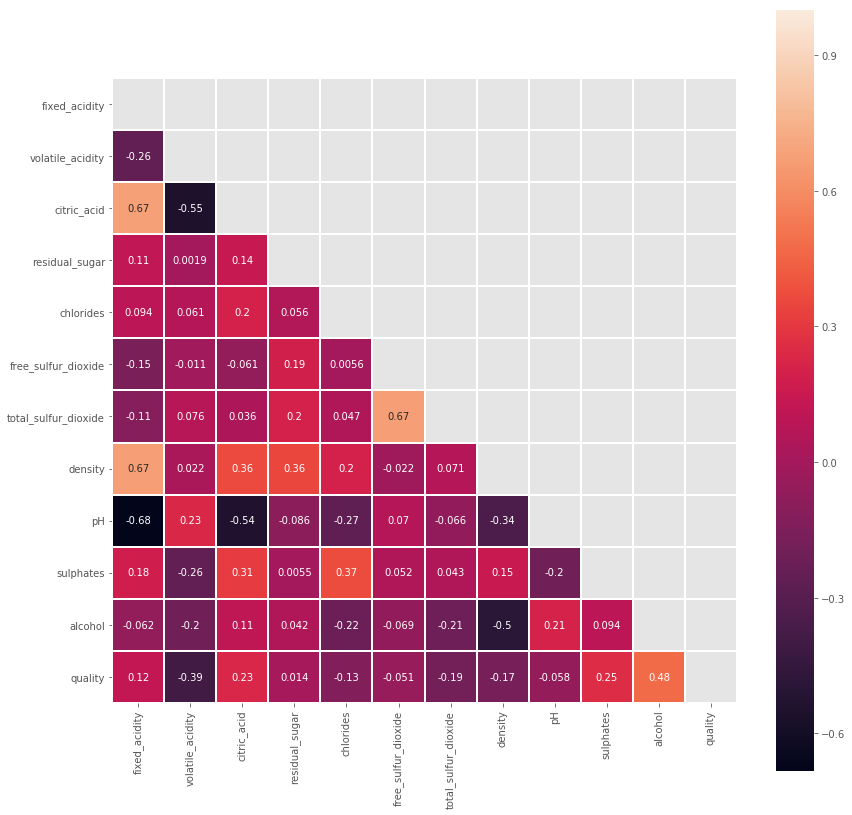

In [15]:
# Create Correlation Object
corr = df_wine_red.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

plt.figure(figsize = (14,14))
sns.heatmap(corr, mask = mask, square=True, linewidths=1, annot=True,)
plt.show()

For now mulitcollinarity will be ignored as this model is just to show how to use a predictive model in a Docker hub. The applicability of the model is not essential.

## Min / Max of Columns
The following calculates the minimum and maximum for each column. this information might be used as a description in the final Flask App, letting the user know the expected range of values.

### Minimum

In [16]:
#df_wine_red.min(axis=0)

### Maximum

In [17]:
#df_wine_red.max(axis=0)


## Anova Report

In [18]:
ols_input = """quality ~ fixed_acidity + volatile_acidity + 
citric_acid + residual_sugar + +chlorides + pH + free_sulfur_dioxide + 
total_sulfur_dioxide + density + sulphates + alcohol"""

results = ols(ols_input, data=df_wine_red).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Fri, 28 Feb 2020   Prob (F-statistic):          1.79e-145
Time:                        17:16:52   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:                    1587   BIC:                             3227.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               21.9652     21.195      1.036      0.300     -19.607      63.538
fixed_acidity            0.0250      0.026      0.963      0.336      -0.026       0.076
volatile_acidity        -1.0836      0.121     -8.948      0.000      -1.321      -0.846
citric_acid             -0.1826      0.147     -1.240      0.215      -0.471       0.106
residual_sugar           0.0163      0.015      1.089      0.276      -0.013       0.046
chlorides               -1.8742      0.419     -4.470      0.000      -2.697      -1.052
pH                      -0.4137      0.192     -2.159      0.031      -0.789      -0.038
free_sulfur_dioxide      0.0044      0.002      2.009      0.045       0.000       0.009
total_sulfur_dioxide    -0.0033      0.001     -4.480      0.000      -0.005      -0.002
density                -17.8812     21.633     -0.827      0.409     -60.314      24.551
sulphates                0.9163      0.114      8.014      0.000       0.692       1.141
alcohol                  0.2762      0.026     10.429      0.000       0.224       0.328
==============================================================================
Omnibus:                       27.376   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.965
Skew:                          -0.168   Prob(JB):                     1.27e-09
Kurtosis:                       3.708   Cond. No.                     1.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## VIF

### Preparation

In [19]:
# Predictor Variables
df_wine_red_X = df_wine_red.drop('quality', axis=1)

# Gather Features
features = "+".join(df_wine_red_X.columns)

# Return X and y from Multivariable Regression
y, X = dmatrices('quality ~' + features, df_wine_red, return_type='dataframe')

### Analysis

In [20]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round(1)

,VIF Factor,features
0,1710538.5,Intercept
1,7.8,fixed_acidity
2,1.8,volatile_acidity
3,3.1,citric_acid
4,1.7,residual_sugar
5,1.5,chlorides
6,2.0,free_sulfur_dioxide
7,2.2,total_sulfur_dioxide
8,6.3,density
9,3.3,pH


# Notebook-Based Flow
For a comparison to the SKLearn SageMaker tools, I will use standard non-SageMaker methods to develop a Random Forest Regression model and evaluate its performance.

## Processing

In [21]:
# Check Input Data Shape
df_wine_red.shape

(1599, 12)

### Split Features and Labels

In [22]:
y = df_wine_red.quality
X = df_wine_red.drop('quality', axis=1)

In [23]:
y.shape

(1599,)

In [24]:
X.shape

(1599, 11)

### Split into Training and Test Sets

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=seed, 
                                                    stratify=y)

### Scale Feature Data

In [26]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
print(X_train.shape)
print(X_test.shape)

(1279, 11)
(320, 11)


### Convert Training Data to Float32

In [28]:
X_train = X_train.astype('float32')

## Training

### Grid Search
First we define the grid search paramaters.

In [29]:
model = RandomForestRegressor(random_state = seed)

param_grid = { 
    'n_estimators' : [100, 500, 750],
    'max_features' : [None, 'auto', 'sqrt', 'log2'],
    'max_depth': [None, 5, 3, 1]
    }

num_folds = 10

kfold = KFold(n_splits=num_folds, random_state=seed)

grid = GridSearchCV(estimator=model,
                    cv=kfold,
                    param_grid=param_grid,
                    scoring='r2',
                    refit=True,
                    verbose=1)

grid

GridSearchCV(cv=KFold(n_splits=10, random_state=5590, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=5590, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 500, 750], 'max_features': [None, 'auto', 'sqrt', 'log2'], 'max_depth': [None, 5, 3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

Then we fit the grid search to the scaled training data.

In [35]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  7.6min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=5590, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=5590, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 500, 750], 'max_features': [None, 'auto', 'sqrt', 'log2'], 'max_depth': [None, 5, 3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

After performing a grid search we'll look at the best parameters that were returned.

In [36]:
print("Best: %f using %s" % (grid.best_score_, 
                             grid.best_params_))

Best: 0.474919 using {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 750}


## Cross Validation Method Test

In [57]:
clf = grid.best_estimator_
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

### R2

In [58]:
scores = cross_val_score(clf, X_train, y_train, scoring = 'r2', cv=10)

In [59]:
print(scores)
print(scores.mean())

[0.47376621 0.48663214 0.41035474 0.38981614 0.50314771 0.57431365
 0.44079092 0.49188538 0.48599683 0.49262504]
0.47493287736270917


### Root Mean Square Error

In [60]:
scores = cross_val_score(clf, X_train, y_train, scoring = 'neg_mean_squared_error', cv=10)

In [75]:
print(scores)
scores_abs = np.absolute(scores)
print(scores_abs)
rsme = np.sqrt(scores_abs)
print(rsme)
print(np.mean(rsme))

[-0.37090746 -0.3529404  -0.38637888 -0.39804962 -0.2935201  -0.28340983
 -0.28834218 -0.41371149 -0.29637378 -0.31576848]
[0.37090746 0.3529404  0.38637888 0.39804962 0.2935201  0.28340983
 0.28834218 0.41371149 0.29637378 0.31576848]
[0.60902172 0.59408787 0.62159382 0.63091174 0.54177495 0.5323625
 0.53697503 0.64320408 0.54440222 0.56193281]
0.5816266745490558


# Evaluate

In [38]:
model = grid.best_estimator_
y_pred = model.predict(X_test)

## Single Pass

In [49]:
print("RMSE for  RF Regressor: %.2f" 
      %(mean_squared_error(y_test,y_pred)))
print("r2 for RF Regressor: %.2f" 
      %(r2_score(y_test,y_pred)))

RMSE for  RF Regressor: 0.32
r2 for RF Regressor: 0.51


## Cross Validate

In [51]:
scores = cross_val_score(model, X_test, y_test, scoring = 'r2', cv=10)

0.4052161984999739


In [52]:
print(scores)
print(scores.mean())

[0.39387665 0.41053796 0.46897867 0.37959042 0.52594668 0.36616092
 0.16522424 0.43261341 0.60328069 0.30595235]
0.4052161984999739
